In [1]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class PairedSRDataset(Dataset):
    def __init__(self, lr_folder, hr_folder, scale=4, lr_size=(80, 80), hr_size=(320, 320)):
        self.lr_folder = lr_folder
        self.hr_folder = hr_folder
        self.filenames = sorted(os.listdir(lr_folder))
        self.scale = scale
        self.lr_size = lr_size
        self.hr_size = hr_size

        self.lr_transform = transforms.Compose([
            transforms.Resize(self.lr_size),
            transforms.ToTensor()
        ])
        self.hr_transform = transforms.Compose([
            transforms.Resize(self.hr_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        lr_path = os.path.join(self.lr_folder, filename)
        hr_path = os.path.join(self.hr_folder, filename)

        lr = Image.open(lr_path).convert('RGB')
        hr = Image.open(hr_path).convert('RGB')

        lr_tensor = self.lr_transform(lr)
        hr_tensor = self.hr_transform(hr)

        return lr_tensor, hr_tensor

In [2]:
from torch.utils.data import DataLoader, random_split

full_train_dataset = PairedSRDataset(
    lr_folder='../dataset/train/LR/',
    hr_folder='../dataset/train/HR/',
    scale=4
)

train_len = int(0.9 * len(full_train_dataset))
val_len = len(full_train_dataset) - train_len
train_set, val_set = random_split(full_train_dataset, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)


In [3]:
test_dataset = PairedSRDataset(
    lr_folder='../dataset/test/LR/',
    hr_folder='../dataset/test/HR/',
    scale=4
)
test_loader = DataLoader(test_dataset, batch_size=1)

In [4]:
from frdn_arch import FRDN
import torch.nn as nn
import torch.optim as optim
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FRDN(in_channels=3, out_channels=3, num_features=64,
             num_blocks=6, num_layers=4, upscale_factor=4, T=4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for lr, hr in train_loader:
        lr, hr = lr.to(device), hr.to(device)
        outputs = model(lr)
        if isinstance(outputs, list):
            loss = criterion(outputs[-1], hr)
        else:
            loss = criterion(outputs, hr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}: Train Loss = {avg_loss:.4f}")


Epoch 1: Train Loss = 0.0383
Epoch 2: Train Loss = 0.0355
Epoch 3: Train Loss = 0.0354
Epoch 4: Train Loss = 0.0352
Epoch 5: Train Loss = 0.0351
Epoch 6: Train Loss = 0.0348
Epoch 7: Train Loss = 0.0343
Epoch 8: Train Loss = 0.0339
Epoch 9: Train Loss = 0.0336
Epoch 10: Train Loss = 0.0333


In [5]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
import torch

model.eval()
psnr_total, ssim_total = 0, 0

with torch.no_grad():
    for lr, hr in test_loader:
        lr, hr = lr.to(device), hr.to(device)
        sr = model(lr)[-1]

        sr_np = sr.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        hr_np = hr.squeeze(0).cpu().numpy().transpose(1, 2, 0)

        sr_np = np.clip(sr_np, 0, 1)
        psnr_total += psnr(hr_np, sr_np, data_range=1.0)
        ssim_total += ssim(hr_np, sr_np, multichannel=True, data_range=1.0, channel_axis=2)

print(f"Test PSNR: {psnr_total / len(test_loader):.2f}")
print(f"Test SSIM: {ssim_total / len(test_loader):.4f}")

Test PSNR: 27.68
Test SSIM: 0.7390


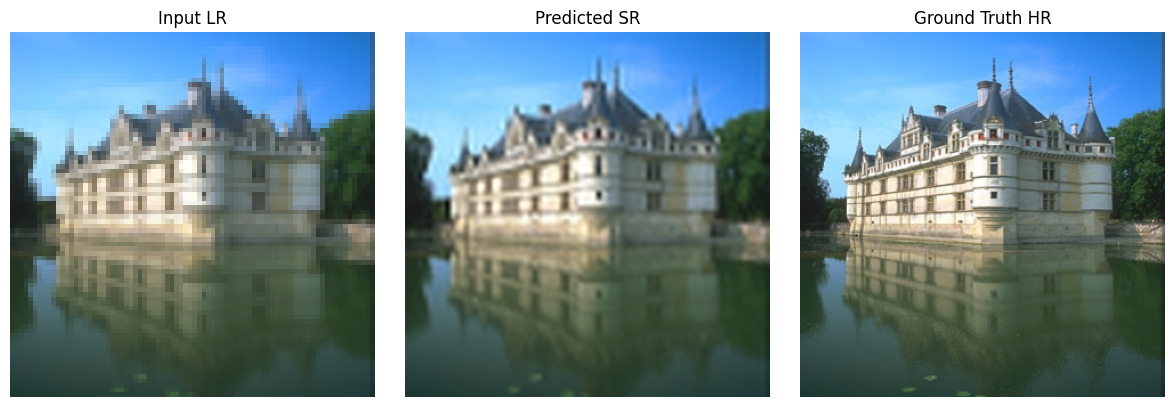

In [6]:
import matplotlib.pyplot as plt
import numpy as np

lr_img, hr_img = test_dataset[0]
lr_img = lr_img.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    sr_img = model(lr_img)[-1]
def to_numpy(img_tensor):
    img = img_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    return np.clip(img, 0, 1)

lr_np = to_numpy(lr_img)
sr_np = to_numpy(sr_img)
hr_np = to_numpy(hr_img.unsqueeze(0))

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(lr_np)
plt.title("Input LR")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sr_np)
plt.title("Predicted SR")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(hr_np)
plt.title("Ground Truth HR")
plt.axis('off')

plt.tight_layout()
plt.show()
